## NORTRIP Control Notebook

This notebook reproduces the `main()` workflow from `src/NORTRIP_Control.py` for interactive runs.

- Set parameters in the next cell (paths and options).
- Run cells top-to-bottom to execute the full model and generate plots.

Notes:
- Imports reference the project `src` directory directly for in-place development.
- Plot selection supports the same options as the CLI (`normal`, `all`, `none`, `temperature`, or a 14-bit string).


In [16]:
# Setup sys.path to import project modules from src
import sys
from pathlib import Path

PROJECT_ROOT = Path("/Users/sindredenby/Documents/metrologisk/NORTRIP-python").resolve()
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

print(f"Using src path: {SRC_DIR}")


Using src path: /Users/sindredenby/Documents/metrologisk/NORTRIP-python/src


In [17]:
# Parameters
from pathlib import Path

# Absolute path to model paths Excel file
PATHS_XLSX = Path("/Users/sindredenby/Documents/metrologisk/NORTRIP-python/model_paths/model_paths_and_files.xlsx")

# Options
READ_AS_TEXT = False
PRINT_RESULTS = False
USE_FORTRAN = False

# Plot selection: "normal" (default), "all", "none", "temperature", or 14-digit 0/1 bitstring
PLOT_SPEC = "normal"

assert PATHS_XLSX.suffix.lower() == ".xlsx", "PATHS_XLSX must point to a .xlsx file"
print(f"Paths file: {PATHS_XLSX}")


Paths file: /Users/sindredenby/Documents/metrologisk/NORTRIP-python/model_paths/model_paths_and_files.xlsx


In [18]:
# Imports
import logging
import numpy as np

import constants
from ospm import OSPM_Main
from functions import running_mean_temperature_func
from read_files import (
    read_road_dust_parameters,
    read_road_dust_paths,
    read_road_dust_input,
)
from initialise import (
    road_dust_initialise_time,
    road_dust_initialise_variables,
    convert_road_dust_input,
)
from calculations import (
    calc_radiation,
    road_dust_surface_wetness,
    set_activity_data,
    activity_state,
    road_dust_emission_model,
    road_dust_dispersion,
    road_dust_concentrations,
    road_dust_convert_variables,
)
from fortran import NORTRIP_fortran_control
from plots import plot_road_dust_result

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger("NORTRIP_Control_Notebook")





In [19]:
# Execute the NORTRIP workflow (mirrors src/NORTRIP_Control.py main())

read_as_text = bool(READ_AS_TEXT)
print_results = bool(PRINT_RESULTS)
use_fortran = bool(USE_FORTRAN)

logger.info(f"Read as inputs as text: {read_as_text}")
logger.info(f"Print results to terminal: {print_results}")
logger.info(f"Run fortran model: {use_fortran}")

# Paths
paths = read_road_dust_paths(read_as_text=read_as_text, paths_xlsx=str(PATHS_XLSX))

# Parameters
model_parameters, model_flags, model_activities = read_road_dust_parameters(
    paths.path_filename_inputparam, read_as_text=read_as_text
)

# Inputs
input_data = read_road_dust_input(
    paths.path_filename_inputdata,
    model_parameters,
    read_as_text,
    print_results,
)

activity_input = input_data.activity
airquality_input = input_data.airquality
meteorology_input = input_data.meteorology
traffic_input = input_data.traffic
initial_input = input_data.initial
metadata_input = input_data.metadata

# Convert inputs
converted_data = convert_road_dust_input(input_data, nodata=metadata_input.nodata)

# Time init
time_config = road_dust_initialise_time(
    converted_data=converted_data,
    metadata=metadata_input,
    use_fortran_flag=use_fortran,
)

if time_config.time_bad:
    logger.error("Time configuration failed - stopping execution")
else:
    # Variables init
    model_variables = road_dust_initialise_variables(
        time_config=time_config,
        converted_data=converted_data,
        initial_data=initial_input,
        metadata=metadata_input,
        airquality_data=airquality_input,
        model_parameters=model_parameters,
        model_flags=model_flags,
    )

    if use_fortran:
        NORTRIP_fortran_control()

    # Activity state
    state = activity_state()

    # Main model loop
    for ro in range(constants.n_roads):
        calc_radiation(
            model_variables=model_variables,
            time_config=time_config,
            converted_data=converted_data,
            metadata=metadata_input,
            initial_data=initial_input,
            model_flags=model_flags,
            model_parameters=model_parameters,
            meteorology_data=meteorology_input,
        )

        for tr in range(model_parameters.num_track):
            # Set the road meteo data
            if meteorology_input.T_sub_available:
                model_variables.road_meteo_data[constants.T_sub_index, :, tr, ro] = (
                    converted_data.meteo_data[constants.T_sub_input_index, :, ro]
                )
            else:
                model_variables.road_meteo_data[constants.T_sub_index, :, tr, ro] = (
                    running_mean_temperature_func(
                        converted_data.meteo_data[constants.T_a_index, :, ro],
                        model_parameters.sub_surf_average_time,
                        0,
                        time_config.max_time_inputdata,
                        time_config.dt,
                    )
                )

        logger.info("Starting time loop...")

        for tf in range(time_config.min_time, time_config.max_time + 1):
            if model_flags.forecast_hour == 0:
                forecast_index = 0
            else:
                forecast_index = max(
                    0, round(model_flags.forecast_hour / time_config.dt - 1)
                )

            # Print the date
            if converted_data.date_data[constants.hour_index, tf, ro] == 1:
                full_date_str = traffic_input.date_str[1, tf]
                date_str = full_date_str[6:12].strip()

                if forecast_index > 0:
                    logger.info(f"{date_str} F: {model_flags.forecast_hour}")
                else:
                    logger.info(date_str)

            # Forecast loop. This is not a loop if forecast_hour=0 or 1
            for ti in range(tf, tf + forecast_index + 1):
                if ti <= time_config.max_time:
                    # Use road maintenance activity rules to determine activities
                    set_activity_data(
                        ti=ti,
                        ro=ro,
                        time_config=time_config,
                        converted_data=converted_data,
                        model_variables=model_variables,
                        model_flags=model_flags,
                        model_activities=model_activities,
                        model_parameters=model_parameters,
                        state=state,
                    )

                    # Loop through the tracks. Future development since num_track=1
                    for tr in range(model_parameters.num_track):
                        # Calculate road surface conditions
                        road_dust_surface_wetness(
                            ti=ti,
                            tr=tr,
                            ro=ro,
                            time_config=time_config,
                            converted_data=converted_data,
                            model_variables=model_variables,
                            model_parameters=model_parameters,
                            model_flags=model_flags,
                            metadata=metadata_input,
                            input_activity=activity_input,
                            tf=tf,
                            meteorology_input=meteorology_input,
                        )

                        # Calculate road emissions and dust loading
                        road_dust_emission_model(
                            ti=ti,
                            tr=tr,
                            ro=ro,
                            time_config=time_config,
                            converted_data=converted_data,
                            model_variables=model_variables,
                            model_parameters=model_parameters,
                            model_flags=model_flags,
                            metadata=metadata_input,
                            initial_data=initial_input,
                            airquality_data=airquality_input,
                        )

            # Save the forecast surface temperature into the forecast index
            if (
                model_flags.forecast_type_flag > 0
                and tf > time_config.min_time
                and tf + forecast_index <= time_config.max_time
            ):
                forecast_ti = tf + forecast_index
                # Use the first track (tr=0) since num_track is typically 1
                tr_forecast = 0

                # Modelled forecast
                if model_flags.forecast_type_flag == 1:
                    model_variables.forecast_T_s[forecast_ti] = (
                        model_variables.road_meteo_data[
                            constants.T_s_index, forecast_ti, tr_forecast, ro
                        ]
                    )

                # Persistence forecast
                elif model_flags.forecast_type_flag == 2:
                    model_variables.forecast_T_s[forecast_ti] = (
                        model_variables.road_meteo_data[
                            constants.T_s_index, tf - 1, tr_forecast, ro
                        ]
                    )

                # Bias correction forecast. Set use_observed_temperature_init_flag=0
                elif model_flags.forecast_type_flag == 3:
                    model_variables.forecast_T_s[forecast_ti] = (
                        model_variables.road_meteo_data[
                            constants.T_s_index, forecast_ti, tr_forecast, ro
                        ]
                        - model_variables.original_bias_T_s
                    )

                # Linear extrapolation. Set use_observed_temperature_init_flag=0
                elif (
                    model_flags.forecast_type_flag == 4
                    and tf - 1 > time_config.min_time
                ):
                    # Get datenum values for interpolation
                    x_dates = converted_data.date_data[
                        constants.datenum_index, tf - 2 : tf, ro
                    ]
                    y_temps = model_variables.road_meteo_data[
                        constants.T_s_index, tf - 2 : tf, tr_forecast, ro
                    ]
                    target_date = converted_data.date_data[
                        constants.datenum_index, forecast_ti, ro
                    ]

                    # Linear extrapolation using numpy.interp
                    model_variables.forecast_T_s[forecast_ti] = np.interp(
                        target_date, x_dates, y_temps
                    )

        # Put forecast surface temperature into the normal road temperature
        if model_flags.forecast_hour > 0:
            for tr_idx in range(model_parameters.num_track):
                model_variables.road_meteo_data[
                    constants.T_s_index,
                    time_config.min_time : time_config.max_time,
                    tr_idx,
                    ro,
                ] = model_variables.forecast_T_s[
                    time_config.min_time : time_config.max_time
                ]

        # Calculate dispersion factors using ospm or NOx
        if model_flags.use_ospm_flag:
            OSPM_Main()
        else:
            road_dust_dispersion(
                time_config=time_config,
                converted_data=converted_data,
                model_variables=model_variables,
                model_parameters=model_parameters,
                metadata=metadata_input,
                airquality_data=airquality_input,
                ro=ro,
            )

        # Calculate concentrations
        road_dust_concentrations(
            time_config=time_config,
            model_variables=model_variables,
            metadata=metadata_input,
            ro=ro,
        )

        # Put binned balance data into normal arrays
        road_dust_convert_variables(
            model_variables=model_variables,
            metadata=metadata_input,
            ro=ro,
        )

    time_config.min_time = time_config.min_time_save
    time_config.max_time = time_config.max_time_save


    



2025-08-28 16:30:46,264 - NORTRIP_Control_Notebook - INFO - Read as inputs as text: False
2025-08-28 16:30:46,265 - NORTRIP_Control_Notebook - INFO - Print results to terminal: False
2025-08-28 16:30:46,265 - NORTRIP_Control_Notebook - INFO - Run fortran model: False
2025-08-28 16:30:46,265 - read_files.read_road_dust_paths - INFO - Setting paths from Excel file: /Users/sindredenby/Documents/metrologisk/NORTRIP-python/model_paths/model_paths_and_files.xlsx
2025-08-28 16:30:46,316 - read_files.read_road_dust_paths - INFO - Successfully loaded model file paths
2025-08-28 16:30:46,451 - read_files.read_road_dust_parameters.read_model_parameters - INFO - Successfully loaded model parameters
2025-08-28 16:30:46,455 - read_files.read_road_dust_parameters.read_model_flags - INFO - Successfully loaded 43 model flags
2025-08-28 16:30:46,459 - read_files.read_road_dust_parameters.read_model_activities - INFO - Successfully loaded 38 model activities
2025-08-28 16:30:48,089 - read_files.read_road

2025-08-28 16:31:50,702 - plots.plot_road_dust_result - INFO - Plotting figure 13: summary


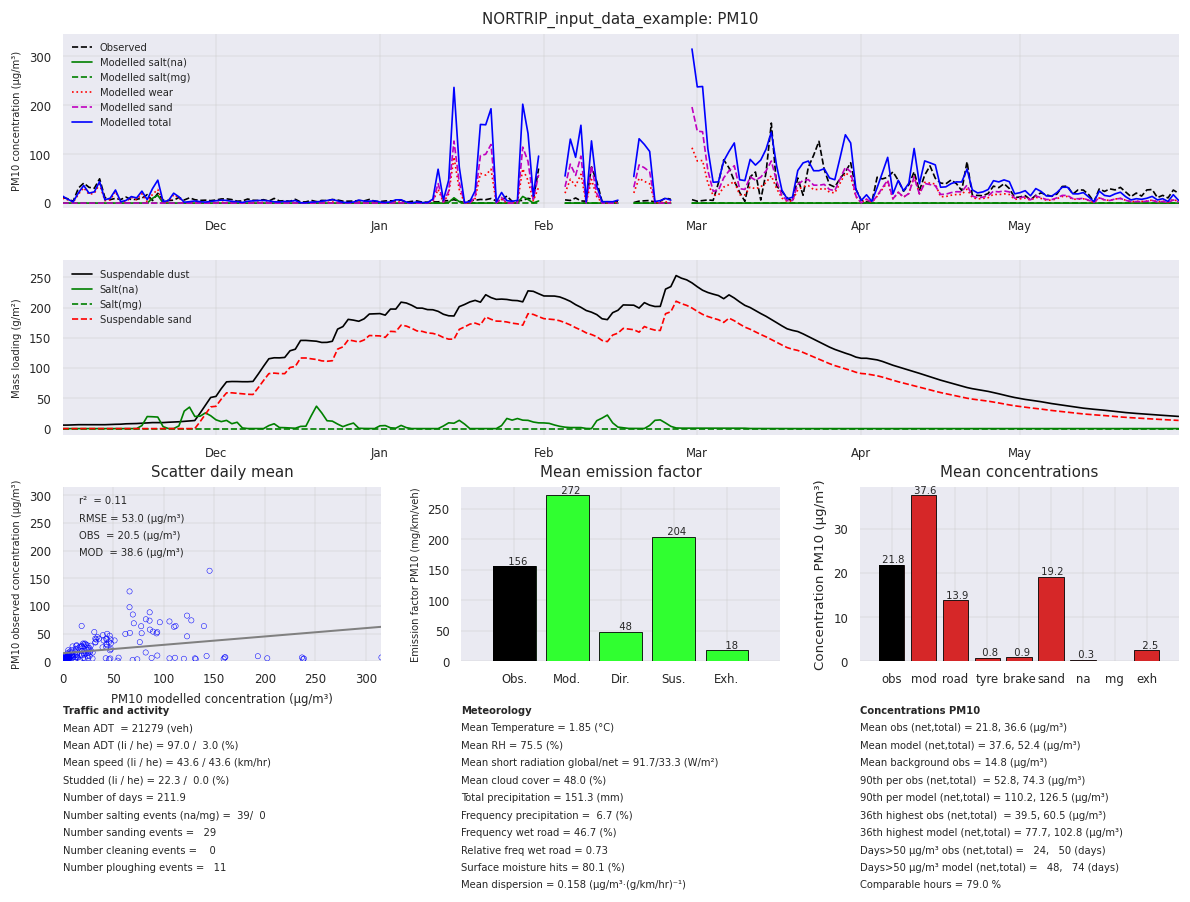

In [21]:
plot_figure = [0,0,0,0,0,0,0,0,0,0,0,0,1,0]
    # Generate plots
plot_road_dust_result(
    time_config=time_config,
    converted_data=converted_data,
    metadata=metadata_input,
    airquality_data=airquality_input,
    model_parameters=model_parameters,
    model_flags=model_flags,
    model_variables=model_variables,
    meteo_input=meteorology_input,
    input_activity=activity_input,
    paths=paths,
    ro=0,
    plot_figure=plot_figure,
)